In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available")

NVIDIA GeForce GTX 1660 SUPER


In [20]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
data = next(iter(train_loader))[0]
mean = data.mean()
std = data.std()
print(mean, std)

normalized_data = (data - mean) / std
one_hot_labels = F.one_hot(train_dataset.targets, num_classes=10).float()

train_loader = DataLoader(
    torch.utils.data.TensorDataset(normalized_data, one_hot_labels),
    batch_size = 64,
    shuffle = True
    )
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_data = next(iter(test_loader))[0]

normalized_test_data = (test_data - mean) / std
one_hot_labels = F.one_hot(test_dataset.targets, num_classes=10).float()

test_loader = DataLoader(
    torch.utils.data.TensorDataset(normalized_test_data, one_hot_labels),
    batch_size = 64,
    shuffle = False
)



tensor(0.1307) tensor(0.3081)


In [86]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(5, 10, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10*7*7, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool1(x)
        
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.dropout(x)
        
        x = x.view(-1, 10*7*7)
        x = self.fc1(x)
        return x

model = Model()


In [87]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        output = model(data)
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    for data, target in test_loader:
        with torch.no_grad():
            output = model(data)
            accuracy = (output.argmax(dim=1) == target.argmax(dim=1)).float().mean()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")



Epoch 1, Loss: 0.1018, accuracy: 1.0000
Epoch 2, Loss: 0.1439, accuracy: 1.0000
Epoch 3, Loss: 0.1259, accuracy: 1.0000
Epoch 4, Loss: 0.0374, accuracy: 1.0000
Epoch 5, Loss: 0.0074, accuracy: 1.0000
Epoch 6, Loss: 0.0382, accuracy: 1.0000
Epoch 7, Loss: 0.0446, accuracy: 1.0000
Epoch 8, Loss: 0.0048, accuracy: 1.0000
Epoch 9, Loss: 0.0080, accuracy: 1.0000
Epoch 10, Loss: 0.0017, accuracy: 1.0000


In [ ]:
torch.save(model.state_dict(), 'mnist_model.pth')

# Search for index of image that is misclassified

62
[[0.   0.   0.   0.   0.   0.69 0.   0.   0.   0.31]]


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

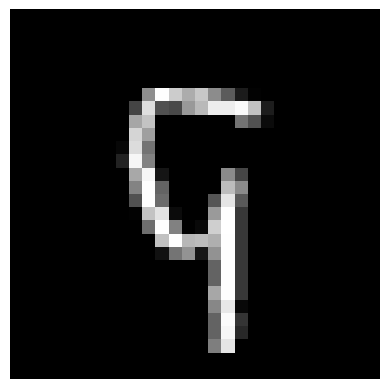

In [88]:
model.eval()
index = None
for i, (data, target) in enumerate(test_loader.dataset):
    with torch.no_grad():
        pred = model(data.unsqueeze(0))
    if np.argmax(F.softmax(pred, dim=1).detach().numpy()) != np.argmax(target.detach().numpy()):
        index = i
        break
print(index)
print(F.softmax(pred, dim=1).detach().numpy().round(2))
plt.imshow(data.squeeze(), cmap='gray')
plt.axis('off')

# Define function to visualize conv layer

In [95]:
def visualize_conv_layer(model, data, conv_index):
    model.eval()

    conv_output = None
    
    # 후크(hook) 함수 정의
    def hook_fn(model, data, output):
        nonlocal conv_output
        conv_output = output.detach()
    
    # 원하는 conv 레이어 찾기
    target_conv = None
    if conv_index == 1:
        target_conv = model.conv1
    elif conv_index == 2:
        target_conv = model.conv2
    elif conv_index == 3:
        target_conv = model.conv3
    
    # 후크 등록
    hook = target_conv.register_forward_hook(hook_fn)
    
    # 데이터 forward
    with torch.no_grad():
        _ = model(data.unsqueeze(0))
    
    # 후크 제거
    hook.remove()
    
    # 필터 출력 시각화
    fig, axes = plt.subplots(1, conv_output.shape[1], figsize=(15, 3))
    for idx in range(conv_output.shape[1]):
        axes[idx].imshow(conv_output[0, idx].numpy(), cmap='gray')
        axes[idx].set_title(f'Filter {idx+1}')
    plt.tight_layout()
    plt.show()
    
    return conv_output

# Visualize conv layer for misclassified image

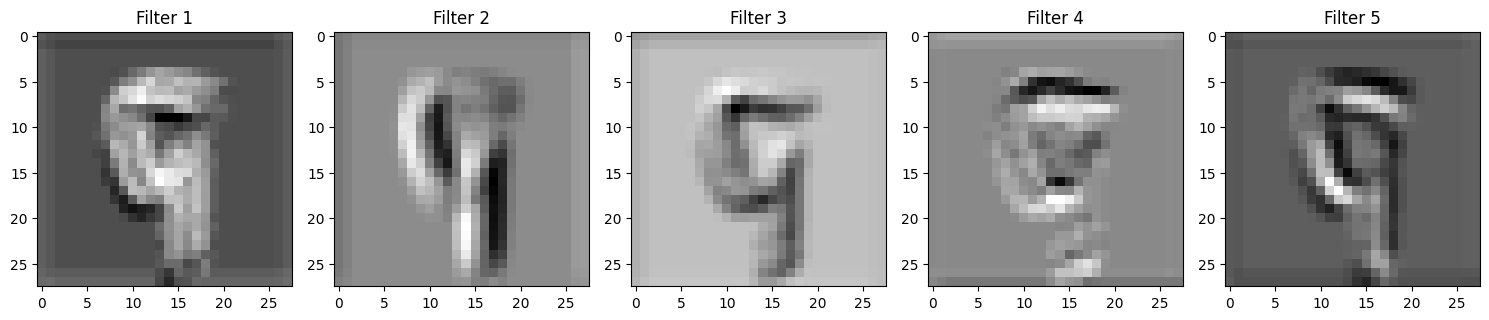

In [114]:
index = 62
image = test_loader.dataset[index][0]
conv_index = 1

output = visualize_conv_layer(model, image, conv_index)

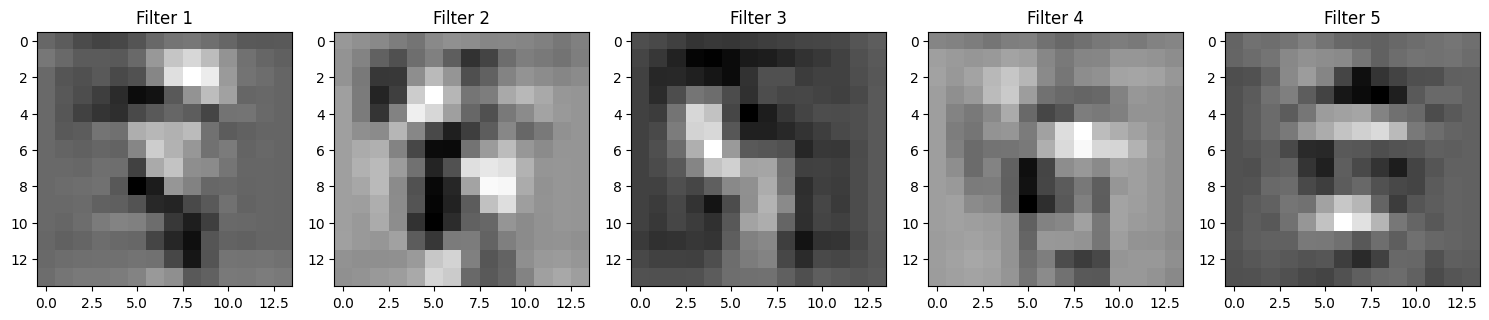

In [115]:
conv_index = 2

output1 = visualize_conv_layer(model, image, conv_index)

# Visualize conv layer for image whose label is 5

In [116]:
model.eval()
index = 0
for i, (data, target) in enumerate(test_loader.dataset):
    with torch.no_grad():
        pred = model(data.unsqueeze(0))
    if np.argmax(target.detach().numpy()) == 5:
        index = i
        break
print(index)

8


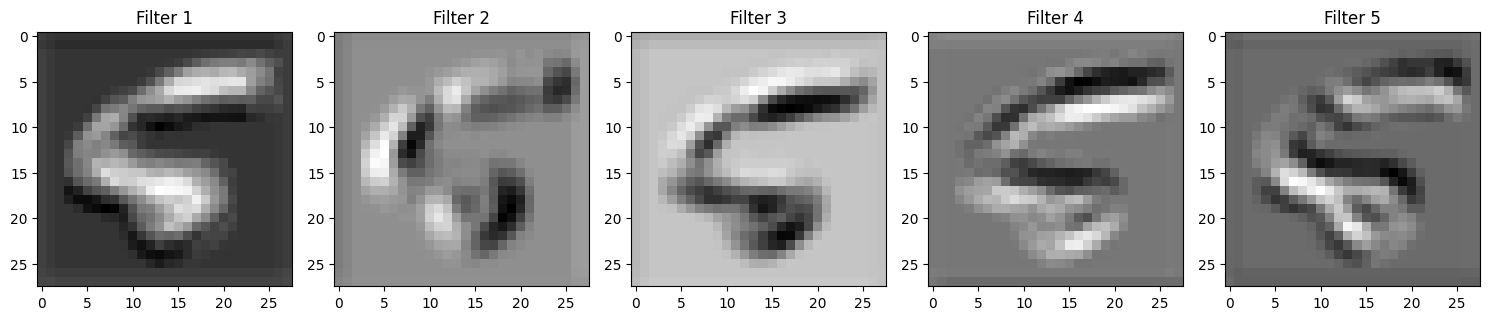

In [118]:
image = test_loader.dataset[index][0]
conv_index = 1

output = visualize_conv_layer(model, image, conv_index)

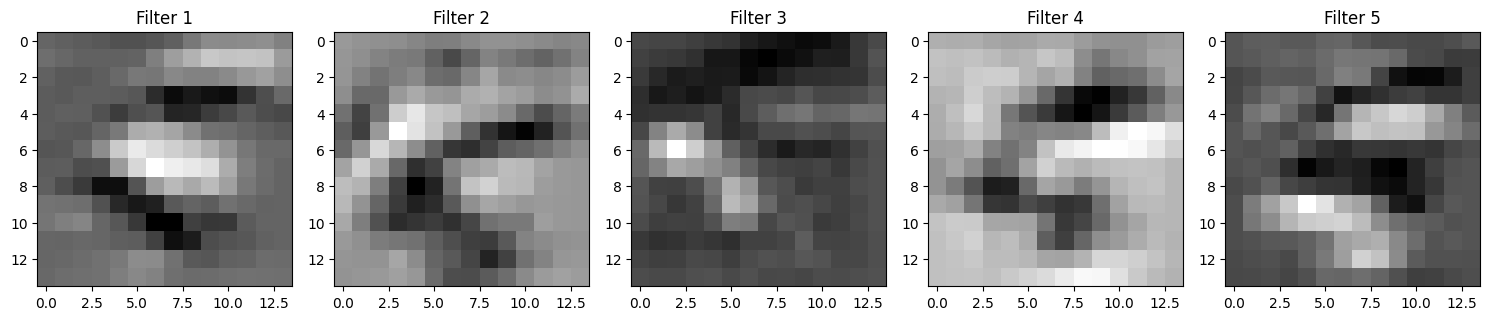

In [119]:
conv_index = 2

output2 = visualize_conv_layer(model, image, conv_index)

# Visualize conv layer for image whose label is 9


In [121]:
model.eval()
index = None
for i, (data, target) in enumerate(test_loader.dataset):
    with torch.no_grad():
        pred = model(data.unsqueeze(0))
    if np.argmax(target.detach().numpy()) == 9:
        index = i
        break
print(index)

7


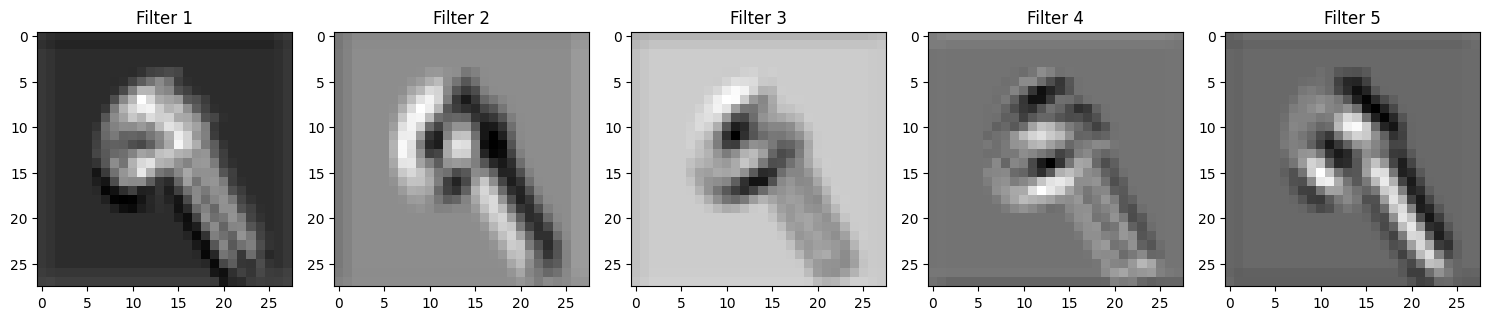

In [122]:
image = test_loader.dataset[index][0]
conv_index = 1

output = visualize_conv_layer(model, image, conv_index)

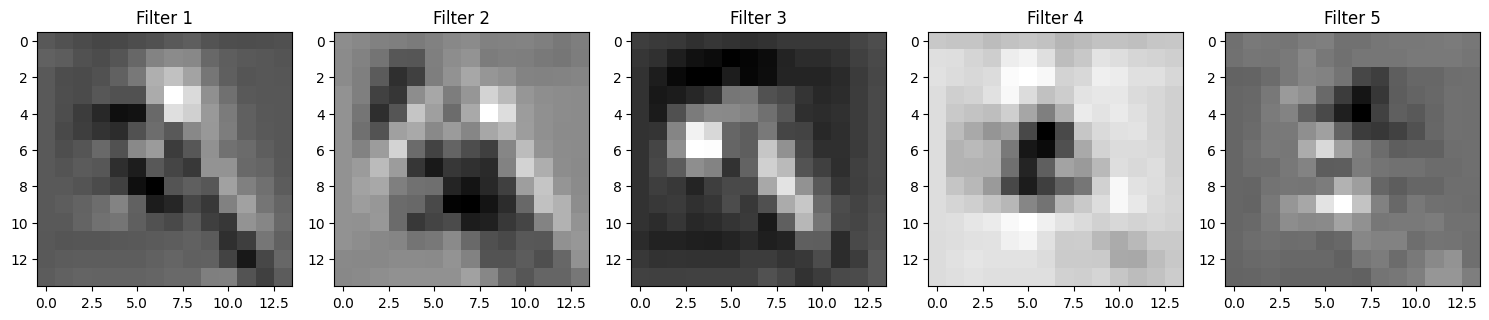

In [123]:
conv_index = 2

output3 = visualize_conv_layer(model, image, conv_index)

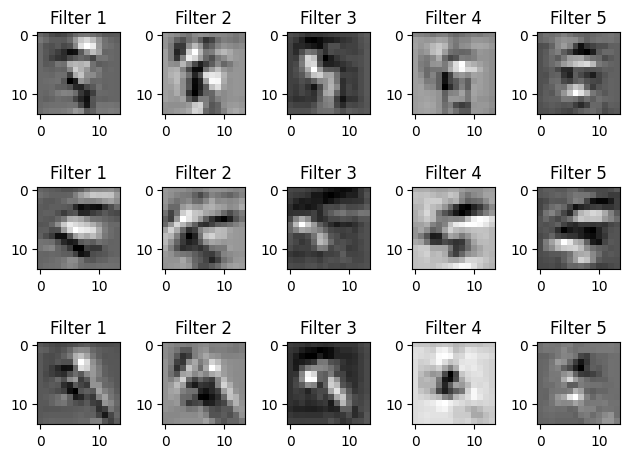

In [124]:
fig, axes = plt.subplots(3, 5)
outputs = [output1, output2, output3]
for idx in range(3):
    for jdx in range(5):
        axes[idx, jdx].imshow(outputs[idx][0, jdx].numpy(), cmap='gray')
        axes[idx, jdx].set_title(f'Filter {jdx+1}')
plt.tight_layout()
plt.show()